In [140]:
import numpy as np
from numpy.random import multivariate_normal
from __future__ import division



from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [141]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
        The state transition model.
        Q : ndarray of shape (n,n)
        The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
        The observation model.
        R : ndarray of shape (m,m)
        The covariance matric for observation noise.
        u : ndarray of shape (n,)
        The control vector.
        """
        self.F =F
        self.epsilon_mu = 0
        self.epsilon_cov =Q
        self.H = H
        self.delta_mean =0
        self.delta_cov = R
        self.u = u
        self.B = np.eye(len(u))
        
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman -
        system.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
        The initial state.
        N : integer
        The number of time steps to evolve.
        Returns
        -------
        states : ndarray of shape (n,N)
        States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
        Observations 0 through N-1, given by each column.
        """
        m, n = self.H.shape
        states = np.zeros((N,len(x0)))
        states[0] = x0
                          
        observations = np.zeros((N,m))
        observations[0] = x0[:m]
    
                          
        for i in range(N-1):
            # making our epsilon and delta noise errors
            eps = multivariate_normal(np.zeros(self.epsilon_cov.shape[0]),self.epsilon_cov)
            delta = multivariate_normal(np.zeros(self.delta_cov.shape[0]),self.delta_cov)
            #the next state and observations
            states[i+1] = np.dot(self.F,states[i]) + np.dot(self.B, self.u)+eps
            observations[i+1] = np.dot(self.H,states[i]) + delta
        return states, observations
    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        Parameters
        ----------
        x : ndarray of shape (n,)
        The initial state estimate.
        P : ndarray of shape (n,n)
        The initial error covariance matrix.
        z : ndarray of shape(m,N)
        Sequence of N observations (each column is an observation).
        Returns
        -------
        out : ndarray of shape (n,N)
        Sequence of state estimates (each column is an estimate).
        """
        m, n = self.H.shape
        N = z.shape[0]
        
        out = np.zeros((N,n))
        out[0] = x
        
        for i in range(N-1):
            # predict stage
            out[i+1] = np.dot(self.F,out[i])+self.u
            P = np.dot(self.F,np.dot(P,self.F.T)) + self.epsilon_cov
            
            #Update stage 
            y = z[i+1]-np.dot(self.H,out[i+1])
            s = np.dot(self.H,np.dot(P,self.H.T))+self.delta_cov
            K = np.dot(P,np.dot(self.H.T, np.linalg.inv(s)))
            out[i+1] = out[i+1]+ np.dot(K,y)
            P = np.dot(np.eye(n)-np.dot(K,self.H),P)
        return out
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.
        Parameters
        ----------
        x : ndarray of shape (n,)
        The current state estimate.
        k : integer
        The number of states to predict.
        Returns
        -------
        out : ndarray of shape (k,n)
        The next k predicted states.
        """
        n = len(x)
        
        out = np.zeros((k,n))
        out[0] = x
        for i in range(k-1):
            out[i+1] = np.dot(self.F,out[i])+self.u
        return out
    def rewind(self,x,k):
        """
        Predict the k states preceding the current state estimate x.
        Parameters
        ----------
        x : ndarray of shape (n,)
        The current state estimate.
        k : integer
        The number of preceding states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
        The k preceding predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
        for i in range(k-1):
            out[i+1] =np.dot(np.linalg.inv(self.F),(out[i]-self.u))
        return out



# Problem 2

In [142]:
Q = .1*np.eye(4)
R = 5000*np.eye(2)
F = np.array([[1,0,.1,0],[0,1,0,.1],[0,0,1,0],[0,0,0,1]])
H = np.array([[1,0,0,0],[0,1,0,0]])
u = np.array([0,0,0,-.98])
kalman = KalmanFilter(F,Q,H,R,u)

# Problem 3

In [143]:
x0 = np.array([0, 0, 300, 600])
states, obs = kalman.evolve(x0, 1250)
plt.subplot(1,2,1)
plt.title('States')
plt.plot(states[:,0], states[:,1])
plt.ylim(0)

plt.subplot(122)
plt.title('Observation Sequence')
plt.scatter(obs[:,0], obs[:,1], s = .3, c = 'r')
plt.ylim(0)

plt.tight_layout()
plt.show()

# Problem 5

In [144]:
#make the velocity by taking the difference of the 9 entries 200-209
v = np.mean(np.diff(obs[200:209]), axis = 1)
#make our initial state
x = np.array([obs[200,0],obs[200,1],v[0],v[1]])
P = 10e6*Q
z = obs[200:801]
estimates = kalman.estimate(x,P,z)      


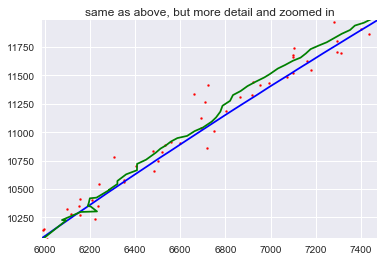

In [145]:
#Plot the state estimates and the actual states
plt.plot(states[:,0], states[:,1], 'b')
plt.scatter(estimates[:,0], estimates[:,1], s=10, c='r')
plt.ylim(0)
plt.plot()
plt.title('State estimates')
plt.show()

#zooming in on the estimates and the observed
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(estimates[:,0], estimates[:,1], 'g')
plt.scatter(obs[:,0], obs[:,1], s=4, c='r')
plt.xlim(states[200, 0], states[250, 0])
plt.ylim(states[200, 1], states[250, 1])
plt.title("same as above, but more detail and zoomed in")
plt.show()

# Problem 7

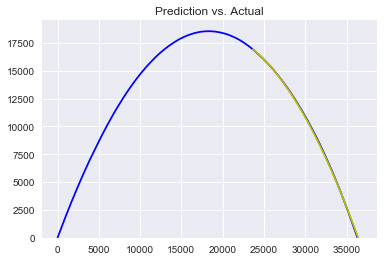

In [146]:
x_0 = estimates[-1]
predictions = kalman.predict(x_0,450)

plt.title('Prediction vs. Actual')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(predictions[:,0], predictions[:,1], 'y')
plt.ylim(0)
plt.show()


plt.title('Prediction vs. Actual Zoomed')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(predictions[:,0], predictions[:,1], 'y')
plt.ylim(0)
plt.xlim(states[1220, 0] - 500, states[1220, 0]+1000)
plt.ylim(0, 100)
plt.show()

# Problem 9

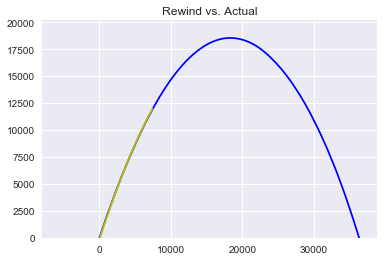

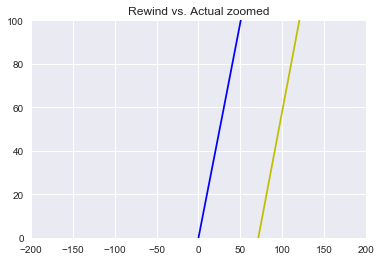

In [147]:
x_0 = estimates[50]
rew = kalman.rewind(x_0,450)

plt.title('Rewind vs. Actual')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(rew[:,0], rew[:,1], 'y')
plt.ylim(0)
plt.show()


plt.title('Rewind vs. Actual zoomed')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(rew[:,0], rew[:,1], 'y')
plt.xlim(-200, 200)
plt.ylim(0, 100)
plt.show()

# Prediction starting at x = 600

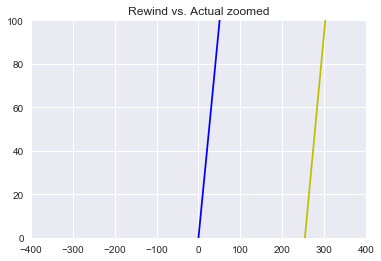

In [150]:
x_0 = estimates[400]
rew = kalman.rewind(x_0,600)

plt.title('Rewind vs. Actual')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(rew[:,0], rew[:,1], 'y')
plt.ylim(0)
plt.show()


plt.title('Rewind vs. Actual zoomed')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(rew[:,0], rew[:,1], 'y')
plt.xlim(-400, 400)
plt.ylim(0, 100)
plt.show()

It appears that the first rewind worked better in terms of the rewind method being closer to the actual. However, the second rewind provides more information. 